In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:
class PINN:
    def __init__(self, x, layers, activation, lr):
        self.x = x
        self.lr = lr
        self.activation = activation
        self.loss_log = []

        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])

        self.surrogate_u = self.surrogate(self.x_tf)
        self.residual    = self.residual(self.surrogate_u, self.x_tf)
        self.loss        = tf.reduce_mean(tf.square(self.residual))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x):
        u = self.neural_net(x, self.weights, self.biases, self.activation)
        return u

    def surrogate(self, x):
        return x*(np.pi - x)*self.net_u(x) + x

    def residual(self, u, x):
        u_x  = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        rhs  = 0
        for i in range(1, 5):
            rhs += i*tf.sin(i*x)
        rhs += 8*tf.sin(8*x)
        return u_xx + rhs

    def callback(self, loss, res, deriv):
        print('Loss:%f,res:%f,deriv:%f'%(loss, res, deriv))

    def train(self, max_iter=40000):
        loss_value = np.inf
        for iter in range(max_iter):
            tf_dict = {
                self.x_tf:self.x
            }
            _, loss_value = self.sess.run([self.optimizer,
                self.loss], tf_dict)
            if iter % 1000 == 0:
                print("第%d次 %f"%(iter, loss_value))
        print("第%d次的损失为%f"%(max_iter, loss_value))

    def predict(self, X_star):
        u_star = self.sess.run(self.surrogate_u, {self.x_tf: X_star})
        return u_star


layers = [1, 20, 20, 20, 20, 1]
activation = tf.tanh
lr = 1e-3
iterations = 20000

In [4]:
def train_model(train_num):
    x = np.linspace(0, np.pi, train_num)[:, None]
    start_time = time.time()
    PINN_tanh = PINN(x, layers, activation, lr)
    print("Start training! train_num:%d"%(train_num))
    PINN_tanh.train(iterations)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return PINN_tanh

In [5]:
def compute_error(model, test_num):
    x_test   = np.linspace(0, np.pi, test_num)[:, None]
    u_test   = x_test
    for i in range(1, 5):
        u_test += np.sin(i*x_test) / i
    u_test  +=  np.sin(8*x_test)/8
    u_pred   = model.predict(x_test)
    L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    return L2_norm

In [6]:
train_nums = np.arange(10, 21, 1)
test_num   = 1000
errors     = []
for train_num in train_nums:
    model = train_model(train_num)
    error = compute_error(model, test_num)
    print("train_num:%d, error:%f"%(train_num, error))
    errors.append(error)
errors = np.array(errors)
np.save('errors_PINN.npy', errors)

Start training! train_num:10
第0次 43.576332
第1000次 5.719227
第2000次 0.000000
第3000次 0.002690
第4000次 0.000000
第5000次 0.000076
第6000次 0.000005
第7000次 0.000000
第8000次 0.001367
第9000次 0.001697
第10000次 0.000028
第11000次 0.002833
第12000次 0.000317
第13000次 0.000006
第14000次 0.001033
第15000次 0.000358
第16000次 0.000048
第17000次 0.000006
第18000次 0.000003
第19000次 0.000020
第20000次的损失为0.000160
Training time: 236.0724
train_num:10, error:0.459955
Start training! train_num:11
第0次 40.991928
第1000次 0.000008
第2000次 0.000000
第3000次 0.000000
第4000次 0.000000
第5000次 0.000278
第6000次 0.000990
第7000次 0.000020
第8000次 0.000000
第9000次 0.017895
第10000次 0.000000
第11000次 0.000001
第12000次 0.000123
第13000次 0.000006
第14000次 0.010709
第15000次 0.000039
第16000次 0.000040
第17000次 0.000000
第18000次 0.000006
第19000次 0.000000
第20000次的损失为0.000000
Training time: 233.9593
train_num:11, error:0.231358
Start training! train_num:12
第0次 44.690308
第1000次 0.000023
第2000次 0.000000
第3000次 0.000000
第4000次 0.000000
第5000次 0.000000
第6000次 0.000000
第

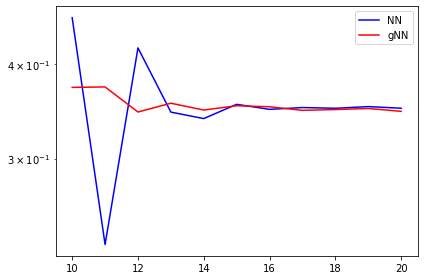

In [8]:
errors_gNN = np.load('errors_gPINN.npy')
errors_NN = np.load('errors_PINN.npy')

plt.plot(train_nums, errors_NN, 'b-', label='NN')
plt.plot(train_nums, errors_gNN, 'r-', label='gNN')
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.savefig('Comparison between NN and gNN L2.pdf')
plt.show()